Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix

Load and preprocess images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Capstone/multi-class/images_multiclass'

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4292 files belonging to 5 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1501 files belonging to 5 classes.


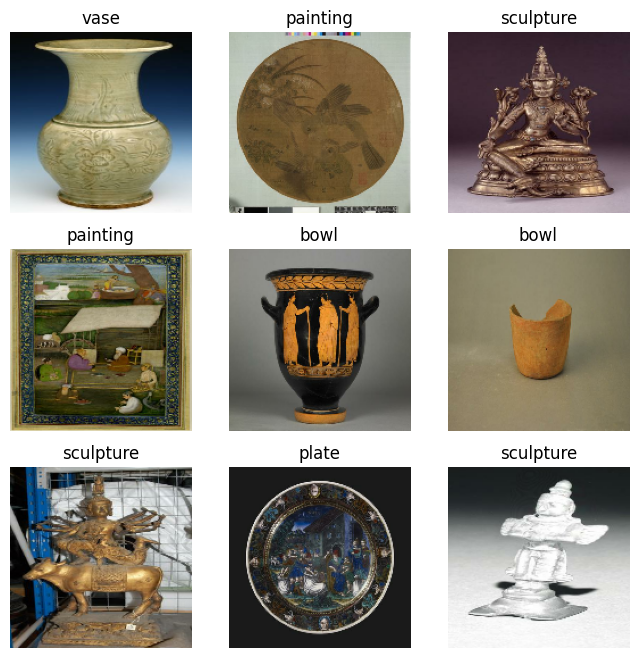

In [ ]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Create test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)  #Take one-fifth of the validation dataset & assign to test_dataset
validation_dataset = validation_dataset.skip(val_batches // 5)  #Excludes images taken for validation dataset

Examining the number of batches, helpful when setting the steps_per_epoch and validation_steps parameters in the fit() method

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 38
Number of test batches: 9


Configure the dataset for performance

In [ ]:
#prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

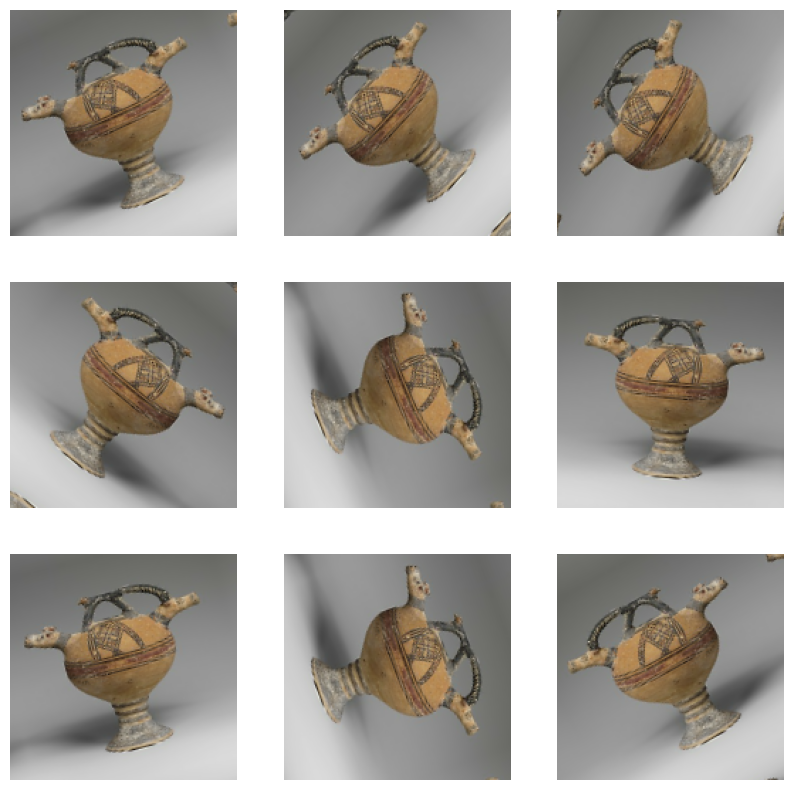

In [ ]:
# Repeatedly apply these layers to the same image & see results
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel values

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
#Rescale pixel values to [-1,1] (from current [0,255]) for use for tf.keras.applications.MobileNetV2
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create base model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
#Observe example batch of images
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature extraction

In [ ]:
#Freeze the convolutional base
base_model.trainable = False

In [ ]:
# Examine the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
#Add classification head to generate predictions from the block of features, using globalaveragepooling layer to convert features to a single 1280 element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Apply dense layer to convert features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
#Build a model chaining together data augmentation rescaling, base model & feature extractor
num_classes = 5
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Compile the model before training it
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Examine the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#Examine the number of trainable variables. A high number of parameters can lead to overfitting & poor generalisation to new data
len(model.trainable_variables)

2

Train the model

In [ ]:
#Initialise the training of the model
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset) #Evaluate the peformance of the model based on validation dataset

38/38 [==============================] - 265s 4s/step - loss: 2.3159 - accuracy: 0.1855


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.32
initial accuracy: 0.19


In [ ]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=1,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights of the best epoch
)

In [ ]:
# Train the model with early stopping callback
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])  # Include the early stopping callback during model training

Epoch 1/10
135/135 [==============================] - 659s 5s/step - loss: 1.5519 - accuracy: 0.3856 - val_loss: 1.4958 - val_accuracy: 0.4081
Epoch 2/10
135/135 [==============================] - 17s 120ms/step - loss: 0.9496 - accuracy: 0.6431 - val_loss: 1.0962 - val_accuracy: 0.5680
Epoch 3/10
135/135 [==============================] - 18s 129ms/step - loss: 0.7236 - accuracy: 0.7279 - val_loss: 0.8785 - val_accuracy: 0.6744
Epoch 4/10
135/135 [==============================] - 17s 120ms/step - loss: 0.6043 - accuracy: 0.7831 - val_loss: 0.7843 - val_accuracy: 0.7230
Epoch 5/10
135/135 [==============================] - 17s 120ms/step - loss: 0.5437 - accuracy: 0.8015 - val_loss: 0.6851 - val_accuracy: 0.7650
Epoch 6/10
135/135 [==============================] - 17s 125ms/step - loss: 0.4955 - accuracy: 0.8148 - val_loss: 0.6588 - val_accuracy: 0.7791
Epoch 7/10
135/135 [==============================] - 18s 124ms/step - loss: 0.4673 - accuracy: 0.8355 - val_loss: 0.6234 - val_accu

Learning curves

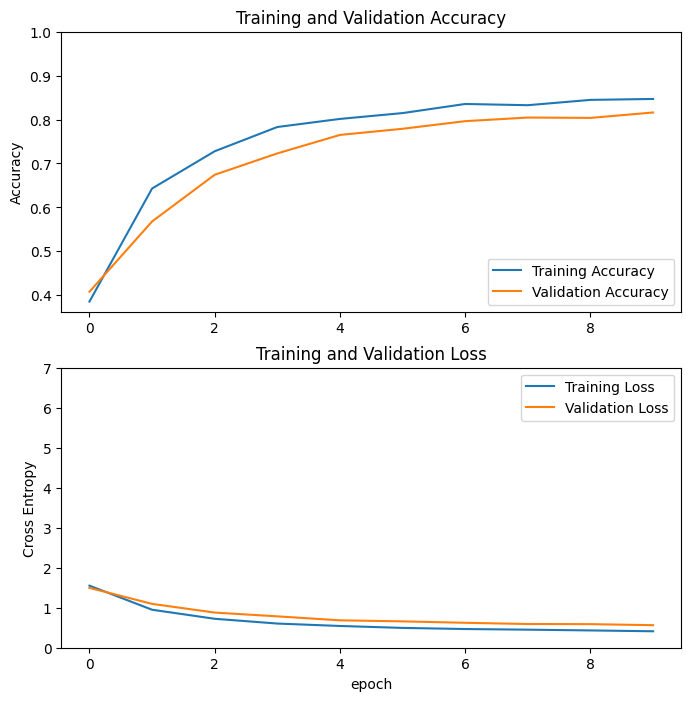

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,7])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save the entire model.
#model.save('/content/drive/MyDrive/Capstone/multi-class/models_multiclass/model1.h5')

In [ ]:
#Reload the fresh keras model
#model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/multi-class/models_multiclass/model1.h5')

# Check its architecture
#model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Fine tuning

In [ ]:
#Unfreeze the top layer of the model 
base_model.trainable = True

In [ ]:
#Examine no. of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
#Set bottom layers to be untrainable
fine_tune_at = 100  #Fine-tune from this layer onwards

for layer in base_model.layers[:fine_tune_at]: 
  layer.trainable = False #Freeze all the layers before the 'fine_tune_at' layer

Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
#continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[early_stopping])

Epoch 10/20
135/135 [==============================] - 21s 126ms/step - loss: 0.4026 - accuracy: 0.8488 - val_loss: 0.5626 - val_accuracy: 0.8087
Epoch 11/20
135/135 [==============================] - 17s 120ms/step - loss: 0.3764 - accuracy: 0.8642 - val_loss: 0.5326 - val_accuracy: 0.8219
Epoch 12/20
135/135 [==============================] - 18s 128ms/step - loss: 0.3695 - accuracy: 0.8651 - val_loss: 0.5338 - val_accuracy: 0.8228


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

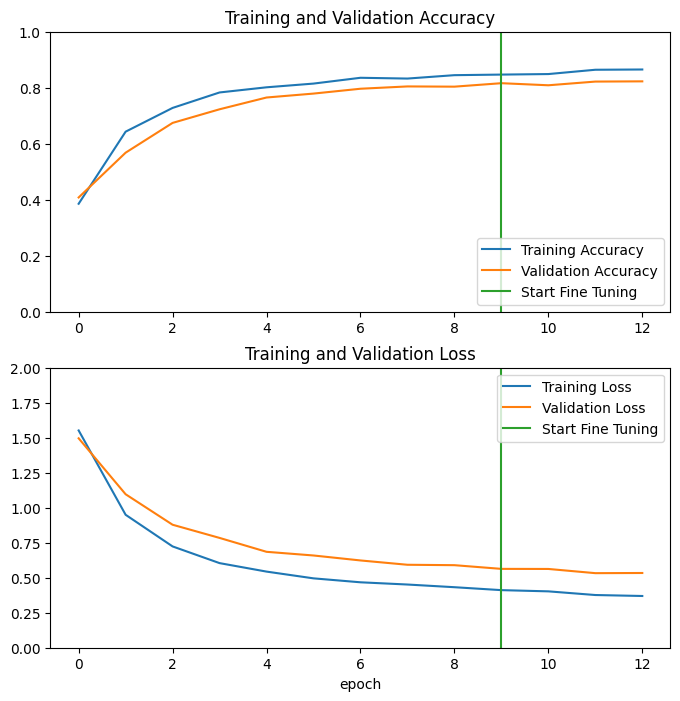

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 2s 101ms/step - loss: 0.4897 - accuracy: 0.8194
Test accuracy : 0.8194444179534912


Predictions:
 [3 0 0 0 4 4 0 0 4 0 0 0 3 1 4 4 1 1 2 4 0 3 2 0 1 4 4 4 4 1 4 2]
Labels:
 [3 1 0 0 4 4 2 0 4 4 0 0 3 1 3 3 3 1 2 4 4 3 2 0 1 3 3 4 4 1 3 2]


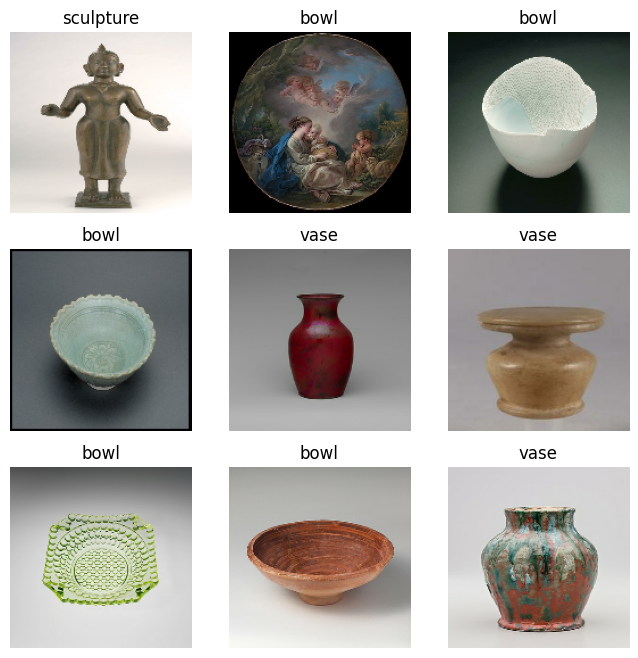

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax since our model returns logits
predictions = tf.math.softmax(predictions)

# Get predicted labels
predictions = tf.math.argmax(predictions, axis = 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(8, 8))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

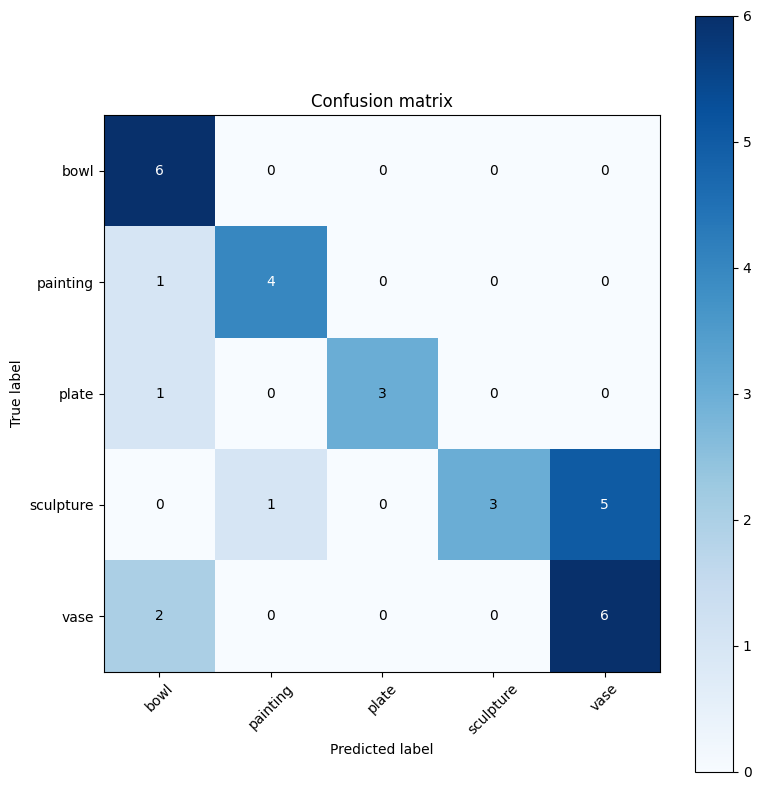

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(label_batch, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion matrix')
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)
plt.tight_layout()
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Add annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.annotate(str(cm[i, j]), xy=(j, i),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')
        
plt.show()

Observations:
- The model predicted fairly well across the different classes. However, there is scope for improvement for 'sculpture' since more than 50% of the images were categorised wrongly

In [ ]:
#Reload the fresh keras model
#model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/multi-class/models_multiclass/model2.h5')

# Check its architecture
#model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#All predictions
predictions = model.predict(test_dataset)

# Apply a softmax since our model returns logits
predictions = tf.math.softmax(predictions)

# Get predicted labels
predictions = tf.math.argmax(predictions, axis = 1)

# Get the labels from the full test dataset
labels = [label for _, label in test_dataset]

# Convert labels to numpy array
labels = np.array(labels)

# Print the labels
print('Labels:\n', labels)
print('Predictions:\n', predictions.numpy())


9/9 [==============================] - 132s 7s/step
Labels:
 [[2 1 3 1 4 2 3 4 4 3 1 2 4 1 4 2 3 3 4 2 3 4 1 1 0 1 0 1 3 3 3 4]
 [0 3 2 0 1 2 0 3 4 3 2 4 2 2 1 3 0 4 0 0 3 3 2 2 1 1 4 0 3 3 2 0]
 [0 0 3 3 2 2 4 4 3 2 1 4 0 1 1 1 3 1 4 0 1 0 4 4 4 1 0 1 0 0 1 0]
 [0 4 0 3 0 1 3 3 3 4 3 4 0 2 2 0 3 2 4 2 4 2 1 1 4 4 3 0 1 2 2 1]
 [3 4 3 2 4 0 2 3 2 3 4 1 1 3 1 3 3 3 2 3 4 0 4 4 0 0 2 1 2 2 1 4]
 [1 3 0 3 4 3 0 0 4 3 0 1 3 0 1 2 2 0 2 2 4 1 2 4 3 0 2 1 3 3 2 1]
 [4 0 4 3 3 3 0 2 2 4 2 3 0 2 0 3 0 1 2 0 3 3 3 1 1 0 3 1 3 0 1 2]
 [0 4 3 4 1 4 3 3 2 0 3 4 0 2 1 1 1 4 4 1 1 2 2 1 4 1 0 2 0 3 3 4]
 [0 2 4 4 1 1 1 2 3 2 1 3 3 1 4 2 4 0 4 3 3 0 3 2 3 4 0 3 3 1 4 3]]
Predictions:
 [4 2 2 2 4 1 1 4 1 0 4 3 0 1 4 4 1 3 1 4 4 0 2 4 2 3 2 2 4 1 4 1 3 1 2 1 4
 3 2 1 1 4 1 2 2 0 1 1 2 2 3 0 3 4 1 3 4 2 0 1 4 1 1 1 3 0 1 4 1 0 2 1 1 4
 4 4 0 2 2 2 3 1 4 3 3 4 2 4 1 0 1 2 4 1 0 1 0 0 3 1 2 2 2 3 1 1 0 4 4 1 3
 3 4 1 0 0 1 2 2 4 3 4 0 0 3 4 1 3 0 0 4 4 0 0 4 2 0 2 3 4 2 0 1 4 0 2 1 0
 2 3 4 3 1 4 2 0 4 0 

In [ ]:
# Save the entire model.
# model.save('/content/drive/MyDrive/Capstone/multi-class/models_multiclass/model2.h5')

In [ ]:
#Reload the fresh keras model
#model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/multi-class/models_multiclass/model2.h5')

# Check its architecture
#model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             